# Compute Summary Motility Metrics
---

#### Overview
This notebook computes summary motility metrics on cell trajectories.

all of the cell trajectories output by the script `src/chlamytracker/scripts/track_cells.py`.

Distributions of select motility metrics are shown.

Summary motility metrics are filtered by trajectory duration.

#### Imports

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chlamytracker.timelapse import Timelapse
from chlamytracker.tracking_metrics import TrajectoryCSVParser
from natsort import natsorted
from tqdm.notebook import tqdm

## Collect csvs of cell trajectories
---

#### Datasets
| Experiment ID | Date          | Substrate               |
|---------------|---------------|-------------------------|
| AMID-04       | 01 March 2024 | Agar microchamber pools |
| AMID-05       | 01 March 2024 | 384-well plate          |

#### Collect csv files

In [2]:
# TODO: remove references to local paths
input_directories = {
    "AMID-04": Path("/Volumes/Microscopy/Babu_frik/Tara/2024-03-01/"),
    "AMID-05": Path("/Volumes/Microscopy/Hina/Tara/2024-03-01/20240301_143720_957"),
}

csv_files = {
    "AMID-04": natsorted(input_directories["AMID-04"].glob("*/processed/*/*_tracks.csv")),
    "AMID-05": natsorted(input_directories["AMID-05"].glob("processed/*_tracks.csv")),
}

out = f"""\
AMID-04 csv files :: {len(csv_files["AMID-04"])}
AMID-05 csv files :: {len(csv_files["AMID-05"])}
----------------------
Total :: {sum([len(csvs) for csvs in csv_files.values()])}
"""
print(out)

AMID-04 csv files :: 644
AMID-05 csv files :: 53
----------------------
Total :: 697



## Experimental parameters
---

#### Table of experimental parameters
| strain | substrate      | position_in_tube | time_in_water |
|--------|----------------|------------------|---------------|
| cc124  | pools          | top              | 4             |
|        | 384-well plate | middle           | 21            |

#### Create mappings from directory structure to experimental parameters

Each subdirectory within `AMID-04` and `AMID-05` contains timelapse microscopy data of _C. smithii_ cells prepared under different conditions.

Cells prepared with different conditions for `AMID-04` were deposited onto

For `AMID-05` each well ID

In [3]:
experimental_parameter_sets = {
    "AMID-04": {
        "S1-Cs3-T": {"strain": "cc1373", "substrate": "pools", "position_in_tube": "top", "time_in_water": 21},  # noqa: E501
        "S2-Cs3-M": {"strain": "cc1373", "substrate": "pools", "position_in_tube": "middle", "time_in_water": 21},  # noqa: E501
        "S3-Cs4-T": {"strain": "cc1373", "substrate": "pools", "position_in_tube": "top", "time_in_water": 4},  # noqa: E501
        "S4-Cs4-M": {"strain": "cc1373", "substrate": "pools", "position_in_tube": "middle", "time_in_water": 4},  # noqa: E501
    },
    "AMID-05": {
        "I02": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "top", "time_in_water": 21},  # noqa: E501
        "J02": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "top", "time_in_water": 21},  # noqa: E501
        "K02": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "top", "time_in_water": 4},  # noqa: E501
        "L02": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "top", "time_in_water": 4},  # noqa: E501
        "I04": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "middle", "time_in_water": 21},  # noqa: E501
        "J04": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "middle", "time_in_water": 21},  # noqa: E501
        "K04": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "middle", "time_in_water": 4},  # noqa: E501
        "L04": {"strain": "cc1373", "substrate": "wells", "position_in_tube": "middle", "time_in_water": 4},  # noqa: E501
    },
}

#### Get frame rates and pixel sizes of raw image data

In [4]:
nd2_files = {
    "AMID-04": next(input_directories["AMID-04"].glob("*/*.nd2")),
    "AMID-05": next(input_directories["AMID-05"].glob("*.nd2")),
}

pixelsizes = {
    "AMID-04": Timelapse(nd2_files["AMID-04"], load=False).pixelsize_um,
    "AMID-05": Timelapse(nd2_files["AMID-05"], load=False).pixelsize_um,
}

framerates = {
    "AMID-04": Timelapse(nd2_files["AMID-04"], load=False).framerate,
    "AMID-05": Timelapse(nd2_files["AMID-05"], load=False).framerate,
}

out = f"""\
Pixelsizes
----------
AMID-04 pixel size :: {pixelsizes["AMID-04"]:.3f} µm/px
AMID-05 pixel size :: {pixelsizes["AMID-05"]:.3f} µm/px

Framerates
----------
AMID-04 frame rate :: {framerates["AMID-04"]:.1f} fps
AMID-05 frame rate :: {framerates["AMID-05"]:.1f} fps
"""
print(out)

Pixelsizes
----------
AMID-04 pixel size :: 0.642 µm/px
AMID-05 pixel size :: 0.433 µm/px

Framerates
----------
AMID-04 frame rate :: 20.0 fps
AMID-05 frame rate :: 20.0 fps



## Compute summary motility metrics
---

In [5]:
# initialize dataframe to collect the summary motility metrics
# for each cell trajectory
motility_metrics_dataframe = pd.DataFrame()

# loop through all the csv files of cell trajectories
for experiment_ID, csvs in csv_files.items():
    for csv in tqdm(csvs):

        # ID tags relevant agar microchamber pools
        if experiment_ID == "AMID-04":
            well_ID = "NA"
            slide_ID = csv.parents[2].name
            timelapse_ID = int(re.findall(r"\d+", csv.parent.name)[-1])
            pool_ID = "x".join(csv.stem.split("_")[1:3])
            # get experimental parameters from slide ID
            experimental_parameters = experimental_parameter_sets[experiment_ID].get(slide_ID)

        # ID tags relevant for 384-well plate
        elif experiment_ID == "AMID-05":
            well_ID = csv.name[4:7]
            slide_ID = "NA"
            timelapse_ID = "NA"
            pool_ID = "NA"
            # get experimental parameters from well ID
            experimental_parameters = experimental_parameter_sets[experiment_ID].get(well_ID)

        else:
            raise ValueError(f"Unknown experiment ID {experiment_ID}")

        ####
        # TODO: remove when becomes unnecessary
        if experimental_parameters is None:
            continue
        ####

        # parse motility data from csv
        framerate = framerates[experiment_ID]
        pixelsize = pixelsizes[experiment_ID]
        cell_trajectories = TrajectoryCSVParser(
            csv, framerate, pixelsize
        )

        # estimate cell count and compute motility measurements
        # for a batch of cell trajectories
        cell_count = cell_trajectories.estimate_cell_count()
        motility_metrics = cell_trajectories.compute_summary_statistics()
        dataframe = pd.DataFrame(motility_metrics)

        # build up dataframe
        dataframe["cell_count"] = cell_count
        dataframe["experiment_ID"] = experiment_ID
        dataframe["strain"] = experimental_parameters["strain"]
        dataframe["substrate"] = experimental_parameters["substrate"]
        dataframe["position_in_tube"] = experimental_parameters["position_in_tube"]
        dataframe["time_in_water"] = experimental_parameters["time_in_water"]
        dataframe["well_ID"] = well_ID
        dataframe["slide_ID"] = slide_ID
        dataframe["timelapse_ID"] = timelapse_ID
        dataframe["pool_ID"] = pool_ID

        # concatenate batch of motility metrics
        motility_metrics_dataframe = pd.concat([motility_metrics_dataframe, dataframe])

# clean up dataframe by removing superfluous `cell_id` column and resetting the index
motility_metrics_dataframe = motility_metrics_dataframe\
    .drop("cell_id", axis=1)\
    .reset_index(drop=True)

  0%|          | 0/644 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [6]:
motility_metrics_dataframe\
    .drop("slide_ID", axis=1)\
    .groupby("experiment_ID")\
    .head(5)

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,experiment_ID,strain,substrate,position_in_tube,time_in_water,well_ID,timelapse_ID,pool_ID
0,3.900780,229.179349,30.311407,16.290295,0.132261,58.752185,7.770602,2.392120,0.0,3,0.013090,3,AMID-04,cc1373,pools,top,21,NA,1,2x2
1,0.850170,46.590193,36.584222,16.127942,0.785234,54.801032,43.031655,4.136839,0.0,4,0.085855,3,AMID-04,cc1373,pools,top,21,NA,1,2x2
2,0.650130,22.472471,19.085556,10.022290,0.849286,34.566119,29.356523,2.799169,0.0,1,0.044499,3,AMID-04,cc1373,pools,top,21,NA,1,2x2
3,3.000600,168.063715,63.766316,15.426156,0.379418,56.010036,21.251188,1.939173,0.0,2,0.011900,3,AMID-04,cc1373,pools,top,21,NA,1,2x2
4,2.850570,112.221645,8.051692,15.485106,0.071748,39.368142,2.824590,4.061436,1.0,9,0.080198,3,AMID-04,cc1373,pools,top,21,NA,1,2x2
1994,19.954072,47.628602,31.877719,0.824480,0.669298,2.386911,1.597555,4.640156,0.0,84,1.763646,19,AMID-05,cc1373,wells,top,21,I02,NA,NA
1995,19.954072,90.879026,32.830895,1.592052,0.361259,4.554410,1.645323,10.093640,1.0,133,1.463484,19,AMID-05,cc1373,wells,top,21,I02,NA,NA
1996,19.954072,169.036297,38.048613,3.997798,0.225091,8.471268,1.906809,3.406205,4.0,44,0.260299,19,AMID-05,cc1373,wells,top,21,I02,NA,NA
1997,19.954072,74.651114,43.324461,1.406703,0.580359,3.741147,2.171209,6.367813,0.0,130,1.741434,19,AMID-05,cc1373,wells,top,21,I02,NA,NA
1998,19.954072,78.577172,45.183941,1.564895,0.575026,3.937902,2.264397,6.307145,0.0,131,1.667151,19,AMID-05,cc1373,wells,top,21,I02,NA,NA


## Filter based on trajectory distance and duration
---

Look at distributions of various metrics to determine threshold criteria.

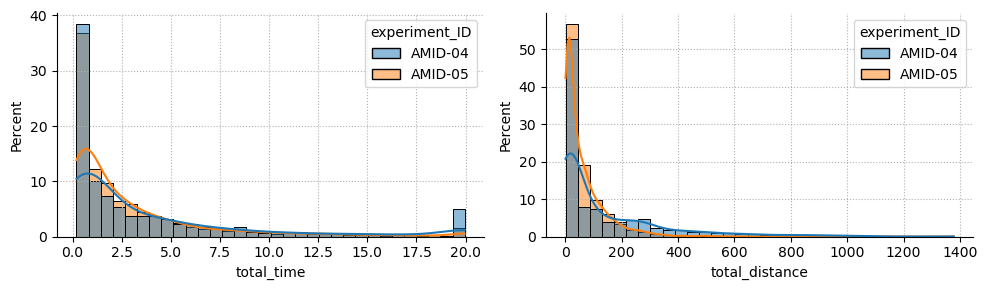

In [7]:
# select metrics
metrics = [
    "total_time",
    "total_distance",
]

# create figure
ncols = len(metrics)
fig, axes = plt.subplots(
    ncols=ncols,
    figsize=(5 * ncols, 3),
)

# split by experiment ID
for i, metric in enumerate(metrics):

    # plot distribution for each metric
    sns.histplot(
        data=motility_metrics_dataframe,
        x=metric,
        bins=32,
        stat="percent",
        common_norm=False,
        hue="experiment_ID",
        kde=True,
        ax=axes[i],
    )
    axes[i].grid(ls=":")
    sns.despine(ax=axes[i])

plt.tight_layout()

In [8]:
# filtering criteria
total_time_threshold = 10
total_distance_threshold = 20

# apply filters
motility_metrics_dataframe_filtered = motility_metrics_dataframe.loc[
    (motility_metrics_dataframe["total_time"] > total_time_threshold) &\
    (motility_metrics_dataframe["total_distance"] > total_distance_threshold)
]

# output stats
num_trajectories = len(motility_metrics_dataframe)
num_filtered = num_trajectories - len(motility_metrics_dataframe_filtered)
num_remaining = len(motility_metrics_dataframe_filtered)

msg = (
    f"Filtered out {num_filtered} of {num_trajectories} trajectories.\n"
    f"{num_remaining} trajectories ({num_remaining/num_trajectories:.0%}) remaining."
)
print(msg)

Filtered out 5825 of 6378 trajectories.
553 trajectories (9%) remaining.


## Export
---

In [9]:
# output directory
output_directory = Path("../data/")

# group dataframe by experiment ID and export to csv
for experiment_ID, dataframe in motility_metrics_dataframe_filtered.groupby("experiment_ID"):

    csv_file = f"{experiment_ID}_summary_motility_metrics.csv"
    dataframe.to_csv(output_directory / csv_file, index=False)